## 메모

`-` 참고

* https://huggingface.co/docs/trl/sft_trainer
* https://github.com/hiyouga/LLaMA-Factory#hardware-requirement
* 메모리 이슈가 있다면 Unsloth를 추가적으로 고려할 수 있음...

`-` 65B 모델 파인튜닝 요구 VRAM

* Full fine-tuning(32bit): 1200GB
* QLoRA(8bit): 80GB
* QLoRA(4bit): 48GB $\leftarrow$ 가장 현실적

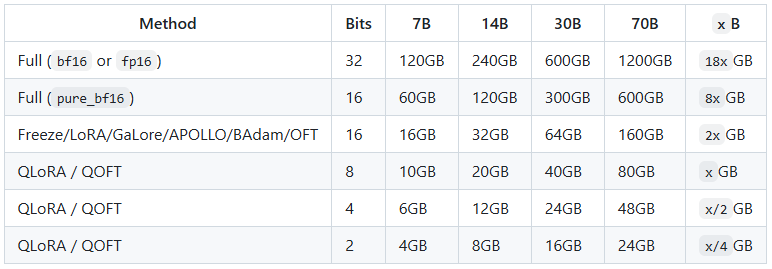

`-` 튜닝 방법

* bitsandbytes quantization: 실수형(BF16) 가중치를 4비트로 양자화
> bfloat16 $\to$ int4로 양자화 이후 학습, 역양자화하여 추론
>
> 성능 저하, 그럼에도 저사양 모델을 사용하는 것보다는 좋은 성능을 낼 것으로 기대
* PEFT Parameter Efficient Fine-Tuning 사용: 모델의 일부분만 새로 학습
> QLoRA Quantized Low-Rank Adaption: 전체 파라미터 행렬을 튜닝하지 않고, 작은 차원의 두 행렬을 학습시킨 후 두 차원의 곱을 전체 파라미터 행렬과 합하여 최종 결과 산출
>
> 파인튜닝 이후, 추론 단계에서 시스템 프롬프트도 추가하면 좋을 것 같음
* flash attention: 더 효율적인 어텐션 연산 수행 $\to$ standard보다 메모리 측면에서 50%, 속도 측면에서 40% 정도의 개선이 생긴다고 하는데... 도커의 우분투 버전 이슈로 사용 불가(GLIBC version 낮음, 더 높은 우분투 OS로 업그레이드 또는 CUDA 버전 다운그레이드 필요) $\to$ 현재 강제로 버전을 맞추어 보았는데, 연산 속도 더 느려짐. 버전 간 충돌 있는듯

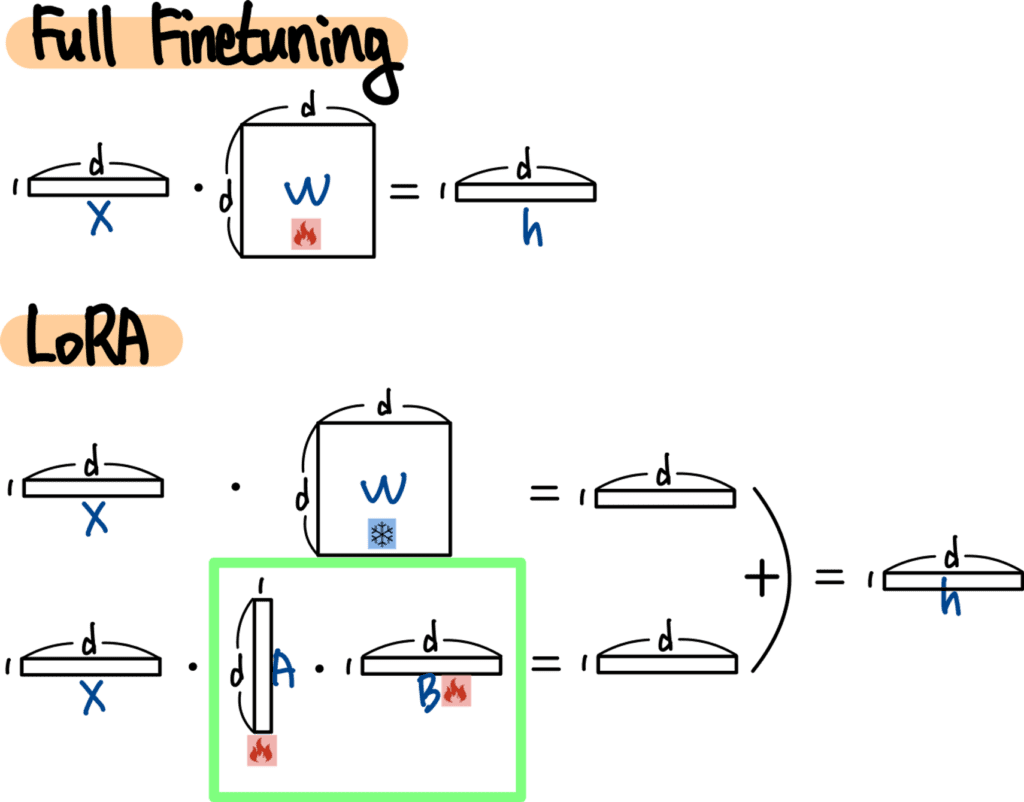

`-` 손실 함수

* token-level cross-entropy loss

$$\mathcal L_{\text{SFT}}(\theta) = - \sum_{t=1}^T \log p_{\theta} (y_t ~ | ~ y_{<t})$$

> 모델 $\theta$에 대하여 target token이 나올 가능성이 얼마나 높은지를 확인

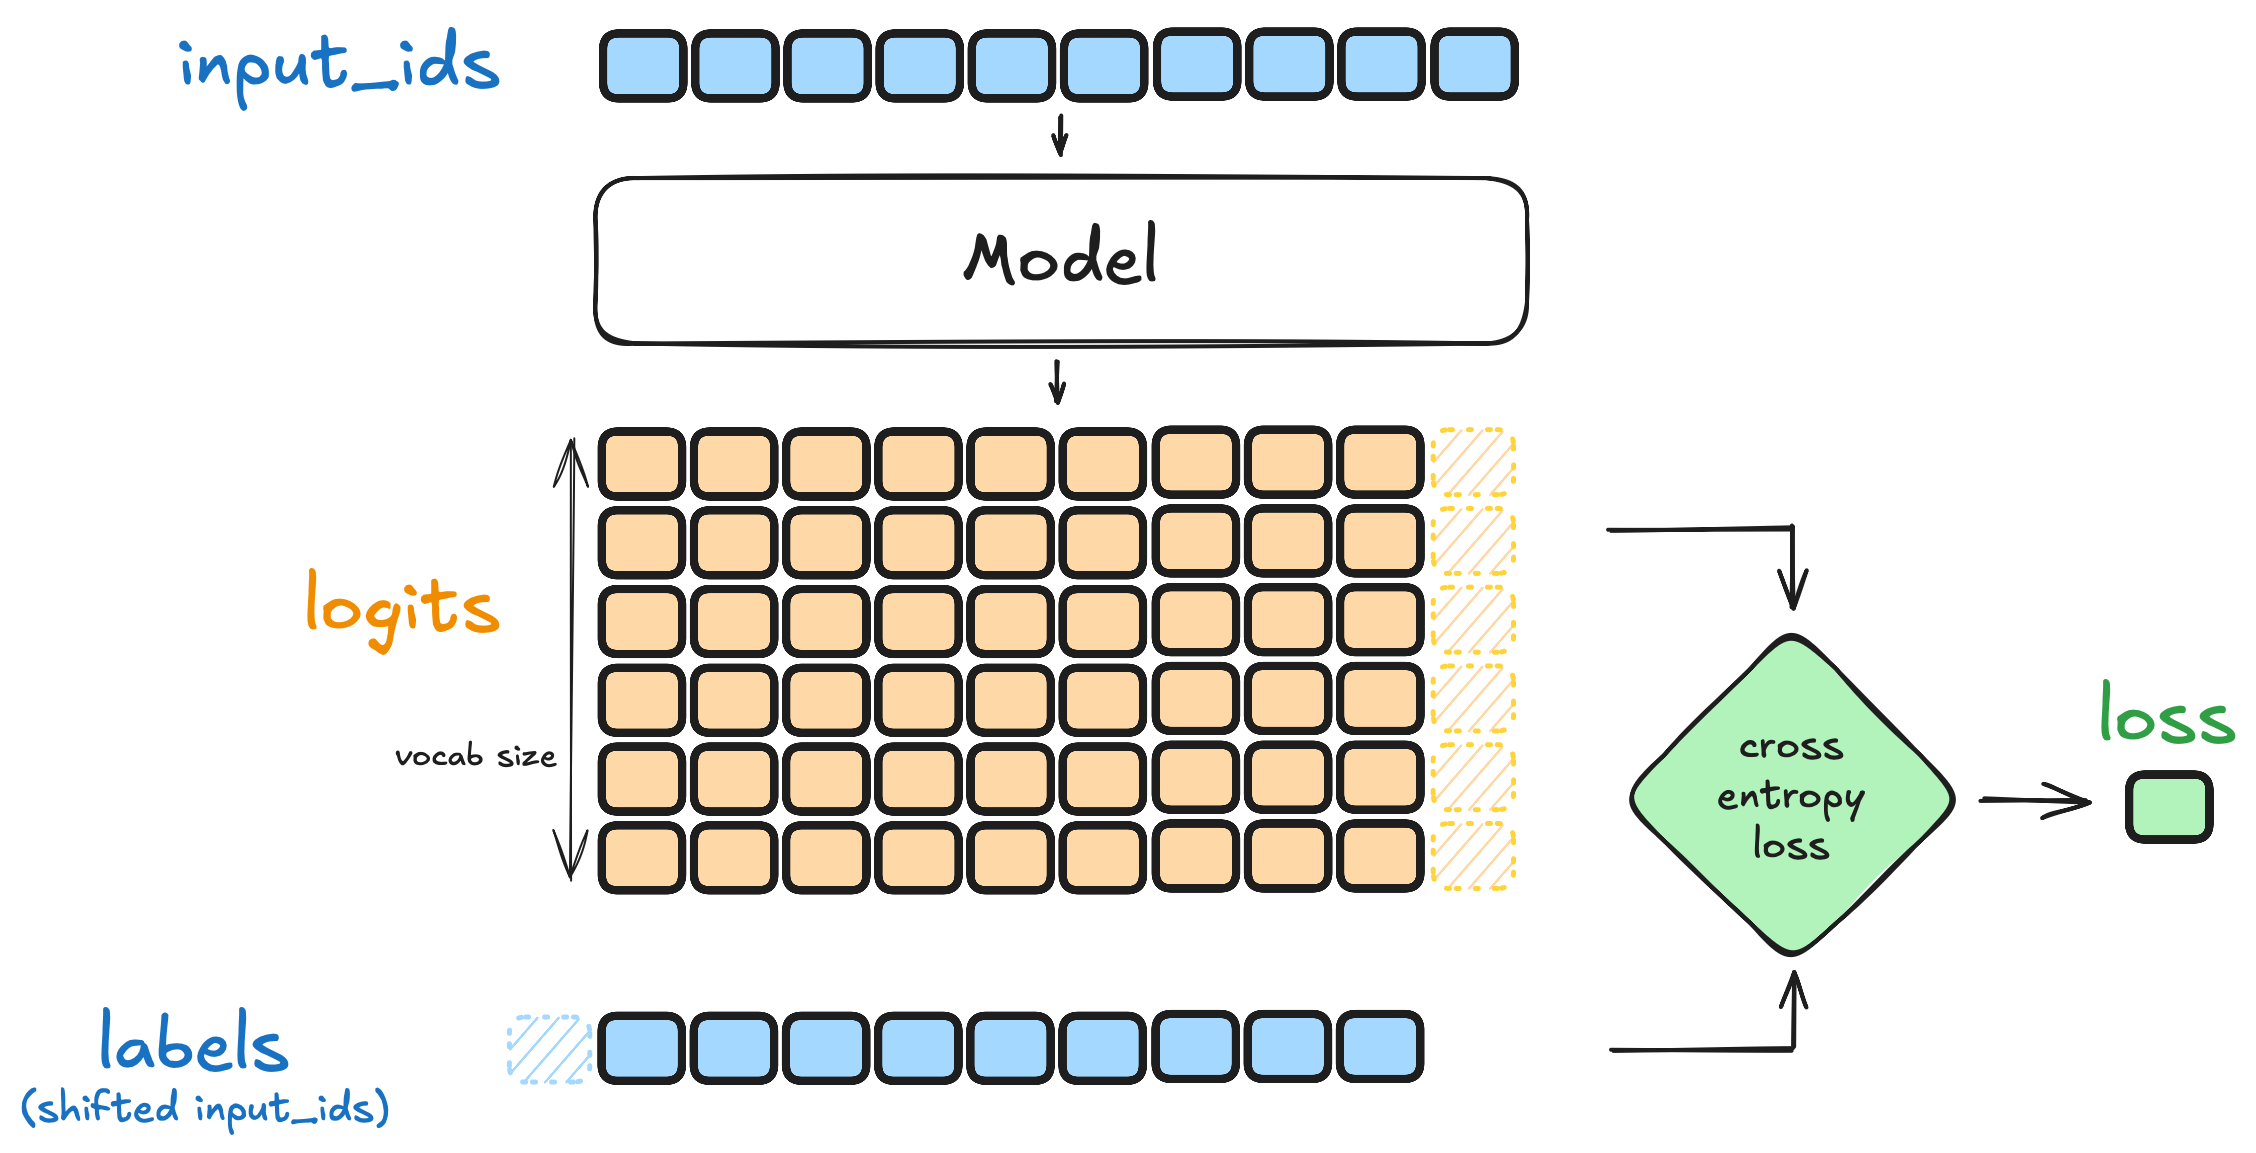

* `SFTTrainer`에서 `compute_loss` 함수를 override하여 재설정할 수 있음

## Imports

In [ ]:
from datasets import load_dataset
from dataclasses import dataclass, field, fields

from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig,
    set_seed
)
from trl import SFTTrainer, SFTConfig, TrlParser, setup_chat_format
from peft import LoraConfig

from sklearn.model_selection import train_test_split

import logging
import torch

import os
import json
import random
import numpy as np

## Dataset

네이버 지식인 베스트 질문 크롤링: 제목/본문/채택된 답변 본문

In [2]:
## 원시 데이터 로드
ds = load_dataset("beomi/KoAlpaca-v1.1a")
columns_to_remove = list(ds["train"].features)  ## 전처리 이후 제거할 기존 피쳐

system_prompt = "당신은 다양한 분야의 전문가들이 제공한 지식과 정보를 바탕으로 만들어진 AI 어시스턴트입니다.\
 사용자들의 질문에 대해 정확하고 유용한 답변을 제공하는 것이 당신의 주요 목표입니다. 복잡한 주제에 대해서도\
 이해하기 쉽게 설명할 수 있으며, 필요한 경우 추가 정보나 관련 예시를 제공할 수 있습니다. 항상 객관적이고 중립적인\
 입장을 유지하면서, 최신 정보를 반영하여 답변해 주세요. 사용자의 질문이 불분명한 경우 추가 설명을 요청하고, 당신이\
 확실하지 않은 정보에 대해서는 솔직히 모른다고 말해주세요."

In [3]:
## 전처리 이전 데이터 예시
ds["train"][0]

{'instruction': '양파는 어떤 식물 부위인가요? 그리고 고구마는 뿌리인가요?',
 'output': '양파는 잎이 아닌 식물의 줄기 부분입니다. 고구마는 식물의 뿌리 부분입니다. \n\n식물의 부위의 구분에 대해 궁금해하는 분이라면 분명 이 질문에 대한 답을 찾고 있을 것입니다. 양파는 잎이 아닌 줄기 부분입니다. 고구마는 다른 질문과 답변에서 언급된 것과 같이 뿌리 부분입니다. 따라서, 양파는 식물의 줄기 부분이 되고, 고구마는 식물의 뿌리 부분입니다.\n\n 덧붙이는 답변: 고구마 줄기도 볶아먹을 수 있나요? \n\n고구마 줄기도 식용으로 볶아먹을 수 있습니다. 하지만 줄기 뿐만 아니라, 잎, 씨, 뿌리까지 모든 부위가 식용으로 활용되기도 합니다. 다만, 한국에서는 일반적으로 뿌리 부분인 고구마를 주로 먹습니다.',
 'url': 'https://kin.naver.com/qna/detail.naver?d1id=11&dirId=1116&docId=55320268'}

In [ ]:
## 전처리 후 저장
train_ds = ds.map(
    lambda sample:
    {"messages": [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": sample["instruction"]},
        {"role": "assistant", "content": sample["output"]}
    ]}
)

train_ds = train_ds.map(remove_columns = columns_to_remove, batched = False)
train_ds = train_ds["train"].train_test_split(test_size = 0.1, seed = 42)

train_ds["train"].to_json("train_dataset.json", orient = "records", force_ascii = False)
train_ds["test"].to_json("test_dataset.json", orient = "records", force_ascii = False)

Creating json from Arrow format:   0%|          | 0/20 [00:00<?, ?ba/s]

Creating json from Arrow format: 100%|██████████| 3/3 [00:00<00:00, 13.43ba/s]


3811926

In [ ]:
## 전처리 이후 데이터 예시
train_ds["train"][0]

{'messages': [{'content': '당신은 다양한 분야의 전문가들이 제공한 지식과 정보를 바탕으로 만들어진 AI 어시스턴트입니다. 사용자들의 질문에 대해 정확하고 유용한 답변을 제공하는 것이 당신의 주요 목표입니다. 복잡한 주제에 대해서도 이해하기 쉽게 설명할 수 있으며, 필요한 경우 추가 정보나 관련 예시를 제공할 수 있습니다. 항상 객관적이고 중립적인 입장을 유지하면서, 최신 정보를 반영하여 답변해 주세요. 사용자의 질문이 불분명한 경우 추가 설명을 요청하고, 당신이 확실하지 않은 정보에 대해서는 솔직히 모른다고 말해주세요.',
   'role': 'system'},
  {'content': '생선찌개를 비린내 없이 끓이는 방법은 무엇인가요?', 'role': 'user'},
  {'content': '생선찌개를 맛있게 끓이는 방법으로 비린내를 없애는 방법이 있습니다. 아래 방법들을 참고해보세요. \n\n- 비린내가 많이 나는 생선찌개에 마지막으로 식초를 넣으면 비린내가 없어집니다. 또한, 생선을 구울 때 껍질에 식초를 바르면 껍질이 벗겨지지 않고 제 모양대로 구울 수 있습니다. \n- 생선찌개를 만들 때 생선이 다 익은 다음 된장을 풀어 넣으면 비린내를 없앨 수 있습니다. \n- 깨끗이 손질한 생선이라도 미처 손질하지 못한 잡티가 붙어 있을 수 있는데, 끓이기 전에 팔팔 끓는 물을 살짝 끼얹으면 비린내도 가시고 국물이 깔끔합니다. \n- 간을 한 국물이 한참 끓으면 그때 생선을 넣습니다. \n\n위 방법을 참고해서 집에서 맛있는 비린내 없는 생선찌개를 만들어 보세요.',
   'role': 'assistant'}]}

## Model: [Llama-3.1-8B-Instruct](https://huggingface.co/meta-llama/Llama-3.1-8B-Instruct)

* 일단 시험용으로 작은 모델인 3.1-8B instruct를 사용

In [ ]:
## TrlParser에 들어갈 class들을 커스터마이징: 하이퍼파라미터 저장
@dataclass  ## 데이터 보관 클래스를 간단하게 구축 가능: __init__, __repr__, __eq()__등의 메소드 자동 생성
class ScriptArguments:
    dataset_path: str = field(default = None, metadata = {"help": "dataset directory"})
    model_name: str = field(default = None, metadata = {"help": "사용할 모델 ID"})

@dataclass
class LoraArguments:
    r: int = field(default = 64, metadata = {"help": "update matrix의 rank. 작을수록 많이 압축하여 품질 저하됨, 메모리 많이 할당됨"})
    lora_alpha: int = field(default = 32, metadata = {"help": "∆Weight scaling factor. lora_alpha / r로 스케일링되며, 학습률 조정. 보통 1/2 수준으로 설정"})
    lora_dropout: float = field(default = 0.05, metadata = {"help": "update matrics에서 dropout 적용 확률"})
    bias: str = field(default = "none", metadata = {"help": "update matrix에 bias를 학습할 것인지 선택"})
    task_type: str = field(default = "CAUSAL_LM", metadata = {"help": "학습할 모형이 무엇인지 지정"})

In [ ]:
def seeding(seed):
    """
    시드 설정으로 인해 성능이 저하될 수 있음. dataloader worker에도 시드 설정이 필요할 수 있음
    """
    set_seed(seed)

    torch.manual_seed(seed)                 ## cpu seed
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)        ## gpu seed
        torch.cuda.manual_seed_all(seed)    ## multi-gpu seed

    torch.backends.cudnn.deterministic = True   ## nondeterministic algorithm을 사용하지 않도록 설정
    torch.backends.cudnn.benchmark = False      ## cuDNN의 여러 convolution algorithm들을 실행하고, 벤치마킹하여 가장 빠른 알고리즘 사용: 안함.

    np.random.seed(seed)
    random.seed(seed)

    os.environ["PYTHONHASHSEED"] = str(seed)    ## hash 알고리즘 관련
    os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"   ## oneDNN 옵션 해제. 수치 연산 순서 고정 (성능 저하, 속도 저하)


def main(script_args, training_args, lora_kwargs):
    ## loading dataset
    train_ds = load_dataset("json", data_files = os.path.join(script_args.dataset_path, "train_dataset.json"), split = "train")
    test_ds = load_dataset("json", data_files = os.path.join(script_args.dataset_path, "test_dataset.json"), split = "train")

    ## 토크나이저 로드 및 설정
    tokenizer = AutoTokenizer.from_pretrained(
        script_args.model_name,
        use_fast = True,            ## Rust로 구현된 Fast Tokenizer 사용 (Qwen, RoPE, ChatGLM 등의 특이한 구조에서는 호환 안됨)
        trust_remote_code = True)   ## 모델 코드 전체 다운로드 후 사용
    tokenizer.pad_token = tokenizer.eos_token       ## 패딩할 토큰 설정
    tokenizer.padding_side = "left"                 ## 디코더이므로 왼쪽을 패딩 (마지막 토큰을 보고 생성)

    ## 데이터에 템플릿 적용
    def template_dataset(examples):
        return {"text": tokenizer.apply_chat_template(examples["messages"], tokenize = False)}
    
    train_ds = train_ds.map(template_dataset, remove_columns = ["messages"])
    test_ds = test_ds.map(template_dataset, remove_columns = ["messages"])

    ## 2개만 출력하여 확인
    print("======== Log a few random samples from the processed training set ========")
    for index in random.sample(range(len(train_ds)), 2):
        print(train_ds[index]["text"])

    ## 양자화 설정
    bnb_config = BitsAndBytesConfig(
        load_in_4bit = True,                    ## 4비트 양자화
        bnb_4bit_use_double_quant = True,       ## 추가 양자화로 성능 손실 없이 파라미터당 0.4bit 추가 절약
        bnb_4bit_quant_type = "nf4",            ## 양자화 데이터 타입 지정: 4비트 기반 모델 훈련 시 사용
        bnb_4bit_compute_dtype = torch.bfloat16 ## Llama-3.1-8B의 학습 자료형. 저장은 4비트지만, 계산은 양자화 없이
    )

    ## 모델 로드 및 설정
    model = AutoModelForCausalLM.from_pretrained(
        script_args.model_name,
        device_map = "cuda:0",
        use_cache = False,                          ## VRAM 캐시 미사용, 추론 속도 저하. gradienc_checkpointing과 동시 사용 불가
        low_cpu_mem_usage = True,                   ## CPU RAM 사용량 적게...
        attn_implementation = "flash_attention_2",  ## flash_attention 연산 사용
        quantization_config = bnb_config,
        dtype = torch.bfloat16                      ## Llama-3.1-8B의 자료형으로 설정
    )

    if training_args.gradient_checkpointing:
        model.gradient_checkpointing_enable()

    ## 훈련 설정
    peft_config = LoraConfig(**lora_kwargs)

    trainer = SFTTrainer(
        model = model,
        args = training_args,
        train_dataset = train_ds,       ## dataloader 자동 적용됨. trainer.get_train_dataloader
        eval_dataset = test_ds,
        processing_class = tokenizer,
        peft_config = peft_config
    )

    ## 학습이 중단된 경우 이어서 진행할 수 있도록 설정
    checkpoint = None
    if training_args.resume_from_checkpoint is not None:
        checkpoint = training_args.resume_from_checkpoint

    trainer.train(resume_from_checkpoint = checkpoint)
    trainer.save_model()

In [ ]:
if __name__ == "__main__":
    parser = TrlParser((ScriptArguments, SFTConfig, LoraArguments))         ## 따로 저장된 파라미터 파싱
    script_args, training_args, lora_args = parser.parse_args_and_config()

    ## Lora Config에 유효한 입력값만 받을 수 있도록 커스터마이징. 원래 TrlParser에는 LoraConfig를 넣지 못함
    valid_keys = LoraConfig.__init__.__code__.co_varnames
    lora_kwargs = {
        f.name: getattr(lora_args, f.name)
        for f in fields(lora_args)
        if f.name in valid_keys
    }

    if training_args.gradient_checkpointing:
        training_args.gradient_checkpointing_kwargs = {"use_reentrant": True}

    # seeding(training_args.seed)

    main(script_args, training_args, lora_kwargs)

## 모델 테스트: VRAM 16GB 요구

In [1]:
import os
import torch
from random import randint
from datasets import load_dataset
from tqdm.auto import tqdm
from transformers import AutoModelForCausalLM, AutoTokenizer

/root/miniconda3/envs/LLM/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


`-` 테스트에 사용될 데이터

In [2]:
test_dataset = load_dataset("json", data_files = os.path.join("", "./test_dataset.json"), split = "train")
random_idx = randint(0, len(test_dataset))
messages = test_dataset[random_idx]["messages"][:2]

In [3]:
messages

[{'content': '당신은 다양한 분야의 전문가들이 제공한 지식과 정보를 바탕으로 만들어진 AI 어시스턴트입니다. 사용자들의 질문에 대해 정확하고 유용한 답변을 제공하는 것이 당신의 주요 목표입니다. 복잡한 주제에 대해서도 이해하기 쉽게 설명할 수 있으며, 필요한 경우 추가 정보나 관련 예시를 제공할 수 있습니다. 항상 객관적이고 중립적인 입장을 유지하면서, 최신 정보를 반영하여 답변해 주세요. 사용자의 질문이 불분명한 경우 추가 설명을 요청하고, 당신이 확실하지 않은 정보에 대해서는 솔직히 모른다고 말해주세요.',
  'role': 'system'},
 {'content': '미세먼지가 나쁨일 때, 어떻게 환기를 해야 할까요?\n미세먼지가 나쁨일 때에도 깨끗한 공기를 유지하려면 어떻게 해야 할까요?',
  'role': 'user'}]

`-` 기존 모델 결과(파인튜닝 이전)

In [4]:
origin_model_name = "meta-llama/Meta-Llama-3.1-8B-Instruct"

origin_model = AutoModelForCausalLM.from_pretrained(origin_model_name, use_cache = False, device_map = "cuda:0", dtype = torch.bfloat16)
origin_tokenizer = AutoTokenizer.from_pretrained(origin_model_name, use_fast = True)
origin_tokenizer.pad_token = origin_tokenizer.eos_token
origin_tokenizer.padding_side = "left"

Loading checkpoint shards: 100%|██████████| 4/4 [00:04<00:00,  1.08s/it]


In [5]:
terminators = [origin_tokenizer.eos_token_id]

input_ids = origin_tokenizer.apply_chat_template(
    messages,
    add_generation_prompt = True,
    return_tensors = "pt").to(origin_model.device)

outputs = origin_model.generate(
    input_ids,
    max_new_tokens = 512,
    eos_token_id = terminators,
    do_sample = True,
    temperature = 0.7,
    top_p = 0.95
)

response = outputs[0][input_ids.shape[-1]:]
print(f"질문:\n{test_dataset[random_idx]["messages"][1]["content"]}\n")
print(f"원답변:\n{test_dataset[random_idx]["messages"][2]["content"]}\n")
print(f"생성답변:\n{origin_tokenizer.decode(response, skip_special_tokens = True)}")

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


질문:
미세먼지가 나쁨일 때, 어떻게 환기를 해야 할까요?
미세먼지가 나쁨일 때에도 깨끗한 공기를 유지하려면 어떻게 해야 할까요?

원답변:
미세먼지가 나쁨일 때에는 창문을 여는 것이 어렵습니다. 하지만 출퇴근 시간과 같이 차량이 많은 시간을 피하고, 일일이 창문을 활짝 열어 환기하는 것보다는 최단시간(3분 이내) 환기를 해야합니다. 창문을 열 때, 써큘레이터나 선풍기를 이용해 공기 흐름을 도와주시는 것이 좋습니다. 추가로, 환기 후에는 분무기를 활용해 공기 중의 미세먼지가 바닥에 떨어진 뒤 물걸레로 집안을 청소해주세요. 하지만 이것이 모든 미세먼지를 제거해주는 것은 아닙니다. 따라서 공기 청정기를 이용하시는 것도 좋은 방법입니다. 그리고 미세먼지 예방에 도움이 되는 것으로 창문에 방충망과 공기 청정 필터를 설치하는 것도 좋은 방법 중 하나입니다.  위의 방법과 함께 유의미한 효과를 볼 수 있을 것입니다.

생성답변:
미세먼지가 나쁨일 때는 환기를 잘 하여 깨끗한 공기를 유지하는 것이 중요합니다. 다음과 같이 환기를 잘 하실 수 있습니다.

1.  **창문을 열고 환기**: 미세먼지가 나쁨일 때 창문을 열고 환기를 하세요. 환기하는 동안 창문을 닫지 마세요. 미세먼지는 공기가 움직일 때 더 쉽게 새어나옵니다.
2.  **공기청정기 사용**: 공기청정기를 사용하여 미세먼지를 잡아주세요. 공기청정기는 미세먼지를 걸러내어 깨끗한 공기를 만들 수 있습니다.
3.  **습도 조절**: 습도가 높을 때 미세먼지가 더 잘 퍼집니다. 공기를 마른 상태에서 환기를 하세요. 에어컨이나 히터를 사용하여 공기를 마르게 하세요.
4.  **미세먼지 측정**: 미세먼지를 측정하여 환기할 때 어떤 상태인지 확인하세요. 미세먼지 측정기는 미세먼지 농도를 측정하여 환기할 때 어떤 상태인지 알려줍니다.
5.  **환기 시간**: 환기 시간을 정해두고 유지하세요. 미세먼지가 나쁨일 때는 매일 환기를 하세요. 환기 시간을 정해두면 미세먼지를 잡아주는 데 도움이 됩니다.
6.  **공기청정기 필터

In [6]:
del origin_model
del origin_tokenizer
torch.cuda.empty_cache()

`-` 파인튜닝 후 모델

In [7]:
SFT_model_name = "./results/llama-3.1-korean-8b-4-epoch/checkpoint-4752"

SFT_model = AutoModelForCausalLM.from_pretrained(SFT_model_name, use_cache = False, device_map = "cuda:0", dtype = torch.bfloat16)
SFT_tokenizer = AutoTokenizer.from_pretrained(SFT_model_name, use_fast = True)
SFT_tokenizer.pad_token = SFT_tokenizer.eos_token
SFT_tokenizer.pad_token_id = SFT_tokenizer.eos_token_id
SFT_tokenizer.padding_side = "left"

Loading checkpoint shards: 100%|██████████| 4/4 [00:05<00:00,  1.25s/it]


In [8]:
terminators = [SFT_tokenizer.eos_token_id]

input_ids = SFT_tokenizer.apply_chat_template(
    messages,
    add_generation_prompt = True,
    return_tensors = "pt").to(SFT_model.device)

outputs = SFT_model.generate(
    input_ids,
    max_new_tokens = 512,
    eos_token_id = terminators,
    do_sample = True,
    temperature = 0.7,
    top_p = 0.95
)

response = outputs[0][input_ids.shape[-1]:]
print(f"질문:\n{test_dataset[random_idx]["messages"][1]["content"]}")
print(f"원답변:\n{test_dataset[random_idx]["messages"][2]["content"]}")
print(f"생성답변:\n{SFT_tokenizer.decode(response, skip_special_tokens = True)}")

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


질문:
미세먼지가 나쁨일 때, 어떻게 환기를 해야 할까요?
미세먼지가 나쁨일 때에도 깨끗한 공기를 유지하려면 어떻게 해야 할까요?
원답변:
미세먼지가 나쁨일 때에는 창문을 여는 것이 어렵습니다. 하지만 출퇴근 시간과 같이 차량이 많은 시간을 피하고, 일일이 창문을 활짝 열어 환기하는 것보다는 최단시간(3분 이내) 환기를 해야합니다. 창문을 열 때, 써큘레이터나 선풍기를 이용해 공기 흐름을 도와주시는 것이 좋습니다. 추가로, 환기 후에는 분무기를 활용해 공기 중의 미세먼지가 바닥에 떨어진 뒤 물걸레로 집안을 청소해주세요. 하지만 이것이 모든 미세먼지를 제거해주는 것은 아닙니다. 따라서 공기 청정기를 이용하시는 것도 좋은 방법입니다. 그리고 미세먼지 예방에 도움이 되는 것으로 창문에 방충망과 공기 청정 필터를 설치하는 것도 좋은 방법 중 하나입니다.  위의 방법과 함께 유의미한 효과를 볼 수 있을 것입니다.
생성답변:
미세먼지가 나쁨일 때, 환기를 위해 다음을 참고해주세요.

1. **지하실을 이용하여 환기** : 지하실에서 환기를 하거나, 창문을 열어 환기를 합니다.
2. **가스레인지 사용을 자제** : 가스레인지 사용은 미세먼지 발생을 증가시켜 환기를 어렵게 만들 수 있습니다. 전기레인지 사용이 더 좋습니다.
3. **전기 가전제품 사용을 줄이기** : 전기 가전제품 사용을 최소화하는 것이 좋습니다. 특히, 미세먼지 발생을 증가시킬 수 있는 제품은 사용을 자제해야 합니다.
4. **공기 청정기 사용** : 공기 청정기를 사용하여 미세먼지를 제거하는 것이 좋습니다. 공기 청정기는 미세먼지와 함께 많은 양의 불순물이 있는 공기를 깨끗한 공기로 변환시켜 주는 제품입니다.
5. **천장 위에 창문을 열어 환기** : 천장 위에 있는 창문을 열어 환기를 합니다. 천장은 미세먼지가 가라앉지 않으므로, 창문을 열어 환기를 해야 합니다.
6. **기러기처럼 창문을 열어 환기** : 기러기처럼 창문을 열어 환기를 합니다. 창문을 열어 환기를 하면, 미세먼지가 빠르게 제거될 